In [1]:
%matplotlib inline
import findspark
findspark.init('C:\spark\spark')
from pyspark import SparkContext 
from pyspark.sql import SQLContext 
import pandas as pd 
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.feature import StandardScaler
import matplotlib.pyplot as plt
from numpy import *

In [2]:
sc = SparkContext('local','NIDS')
sqlc=SQLContext(sc) 
df=pd.read_csv(r'UNSW_NB15_training-set.csv') 
sdf=sqlc.createDataFrame(df)
_df = sdf.select("trans_depth").toPandas()

In [26]:
mean = 0.105982
stdv =0.776911

In [5]:
##1.0 Simulated Data
N=175341
mu, sigma = mean, stdv # mean and standard deviation
rdd = sc.parallelize( random.normal(mu,sigma,N) )
 
##2.0 The Function
#2.1 Kernel Function
 
def spark_density(data, Nout, bw):
    def epan_kernel(x,y,b):
        u=true_divide( (x-y), b)
        return max(0, true_divide( 1, b)*true_divide(3,4)*(1-u**2))     
 
    #derive the minia and maxi used for interpolation
    mini=data.takeOrdered(1, lambda x: x )
    maxi=data.takeOrdered(1, lambda x: -1*x )
    #create an interpolation grid (in fact NOT random this time)
    random_grid = sc.parallelize( linspace(mini, maxi, num=Nout))
    Nin=data.count()
    #compute K(x-xi) Matrix
    kernl=data.cartesian(random_grid).map(lambda x:( float(x[1]),true_divide(epan_kernel(array(x[0]),array(x[1]),bw),Nin) ) )
    #sum up 
    return kernl.reduceByKey( lambda y, x:  y+x )
 
##3.0 Results
density= spark_density(rdd, 128, 0.8).collect()
dens=array(density).transpose()


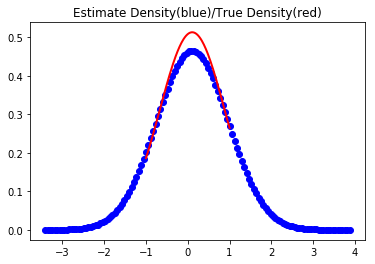

In [33]:
#Plot the estimate
plt.plot(dens[0], dens[1], 'bo')
plt.title("Estimate Density(blue)/True Density(red)")
axis2=linspace(-1, 1,num = 128)
#plot the true density
plt.plot(axis2, 1/(sigma*sqrt(2*pi))*exp(-(axis2-mu)**2/(2*sigma**2)),linewidth=2,color='r')
plt.show()